<a href="https://colab.research.google.com/github/mayanjabbaale/GANs/blob/main/Basic_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, feature_g=64):
        super().__init__()

        self.net = nn.Sequential(
            # z: N x 100 x 1 x 1
            nn.ConvTranspose2d(z_dim, feature_g * 4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            # 7x7

            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            # 14x14

            nn.ConvTranspose2d(feature_g * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # 28x28
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, feature_d=64):
        super().__init__()

        self.net = nn.Sequential(
            # N x 1 x 28 x 28
            nn.Conv2d(1, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 14x14

            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 7x7

            nn.Conv2d(feature_d * 2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

dataset = datasets.MNIST(
    root="MNIST",
    download=True,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

z_dim = 100
lr = 2e-4

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

epochs = 50
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # ===== Train Discriminator =====
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(noise)

        loss_D = (
            criterion(D(real_imgs), real_labels) +
            criterion(D(fake_imgs.detach()), fake_labels)
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ===== Train Generator =====
        loss_G = criterion(D(fake_imgs), real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

Epoch [1/50] | D Loss: 0.7965 | G Loss: 1.9494
Epoch [2/50] | D Loss: 0.6650 | G Loss: 1.5129
Epoch [3/50] | D Loss: 0.6419 | G Loss: 1.3272
Epoch [4/50] | D Loss: 0.6900 | G Loss: 1.3233
Epoch [5/50] | D Loss: 0.6917 | G Loss: 1.8957
Epoch [6/50] | D Loss: 0.7645 | G Loss: 0.8831
Epoch [7/50] | D Loss: 0.5877 | G Loss: 2.3146
Epoch [8/50] | D Loss: 1.3672 | G Loss: 0.3732
Epoch [9/50] | D Loss: 0.6613 | G Loss: 2.1941
Epoch [10/50] | D Loss: 0.6207 | G Loss: 1.7606
Epoch [11/50] | D Loss: 0.9614 | G Loss: 1.8908
Epoch [12/50] | D Loss: 0.6727 | G Loss: 1.8913
Epoch [13/50] | D Loss: 0.7995 | G Loss: 1.6416
Epoch [14/50] | D Loss: 0.7579 | G Loss: 1.5494
Epoch [15/50] | D Loss: 0.7666 | G Loss: 2.5023
Epoch [16/50] | D Loss: 1.5750 | G Loss: 2.8338
Epoch [17/50] | D Loss: 0.7639 | G Loss: 1.7763
Epoch [18/50] | D Loss: 0.6063 | G Loss: 1.8529
Epoch [19/50] | D Loss: 0.7523 | G Loss: 2.6566
Epoch [20/50] | D Loss: 1.3111 | G Loss: 3.2038
Epoch [21/50] | D Loss: 0.7024 | G Loss: 1.5938
E

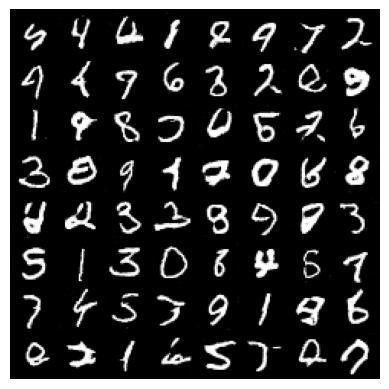

In [7]:
# Visualize samples
with torch.no_grad():
  fake = G(fixed_noise).cpu()
  grid = make_grid(fake, nrow=8, normalize=True)
  plt.imshow(grid.permute(1, 2, 0), cmap="gray")
  plt.axis("off")
  plt.show()